# 四章　ニューラルネットワークの学習

ニューラルネットワークの**学習**とは、出力データと実際の訓練データ(本章では今後**教師データ**と呼ぶ)の間に存在する誤差を最も小さくする重みやバイアスなどのパラメータを算出し、テストデータでそのパラメータの精度を計るという一連の流れのことです。

この学習の目的はテストデータなどの教師データに含まれないデータでも精度の高い演算を行えるようにすること(**汎化能力**を獲得すること)であるため、教師データだけに過度に対応した演算になってしまうこと(**過学習**)は避けねばならない問題です。

ニューラルネットワークの学習では主に**勾配法**と呼ばれる手法が用いられます。その手順をまとめると、以下のようになります。

1. **ミニバッチの作成**…何千何万という膨大な教師データは同時に扱うことができません。そこで大量のデータから100や200程度の一部のデータをランダムに選び出します。この時選ばれたデータを**ミニバッチ**といいます。
2. **損失関数に代入**…ニューラルネットワークの出力データと教師データのミニバッチに存在する誤差を求める関数を**損失関数**といいます。損失関数に代入することでその重みやバイアスのパラメータがいかに悪いかを示すことができます。
3. **勾配を算出**…**偏微分**を利用して損失関数の値を最も減らす方向をベクトルで示します。
4. **パラメータの更新**…3.で示した方向に微小量だけ進みます。その時に進む量(更新する量)を**学習率**といいます。
5. **繰り返す**…1.～4.までの動きを繰り返します。この際繰り返す回数や4.で出てきた学習率などのパラメータは**ハイパーパラメータ**と呼ばれ、人の手で設定しなければなりません。

このような手順は、ミニバッチをランダムで求めていたり、勾配法でパラメータの最小値を求めていることから、**確率的勾配降下法**という名前で呼ばれます。

それでは、1番目の手順から順番に見ていきましょう。

## ミニバッチ学習

前回も用いたMNISTデータセットを用いて教師データ60000個からランダムに10枚を抜き出してミニバッチを作ってみましょう。

In [1]:
import sys,os #まずはMNISTデータセットを読み込む
sys.path.append(os.pardir)
from dataset.mnist import load_mnist
(x_train,t_train),(x_test,t_test)=\
    load_mnist(normalize=True,one_hot_label=True)
print(x_train.shape) 
print(t_train.shape)

(60000, 784)
(60000, 10)


ここでone_hot_labelをTrueにすることで、教師データ(t_train.shapeの10)が正解のラベルのみ1、残りを0とするデータ構造(**one_hot表現**)になります。これは次の損失関数を用いるときに非常に重要になります。

In [2]:
import numpy as np
train_size=x_train.shape[0]
batch_size=10
batch_mask=np.random.choice(train_size,batch_size) #train_size(60000個)からランダムにbatch_size(10枚)選ばれる
x_batch=x_train[batch_mask]
t_batch=t_train[batch_mask]
print(t_batch)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


## 損失関数

損失関数には様々な任意の関数を用いることができますが、一般的には2乗和誤差や交差エントロピー誤差などが用いられます。

### 2乗和誤差

2乗和誤差の数式は以下の通りです。値が小さいほうが誤差は小さくなります。

$$
    E =\frac{1}{2}\sum_{k}(y_k-t_k)^2
$$

In [3]:
def sum_squared_error(y,t): #二乗和誤差の定義
    return 0.5*np.sum((y-t)**2)
y=[0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0] #出力データ(2の確率が最も高い場合)
t=[0,0,1,0,0,0,0,0,0,0] #教師データ(2が正解)
sum_squared_error(np.array(y),np.array(t))

0.09750000000000003

In [4]:
y=[0.1,0.05,0.1,0.0,0.05,0.1,0.0,0.6,0.0,0.0] #7の確率が最も高い場合
sum_squared_error(np.array(y),np.array(t))

0.5975

### 交差エントロピー誤差

交差エントロピー誤差は以下の数式で表されます。

$$
    E = -\sum_{k}t_klogy_k
$$

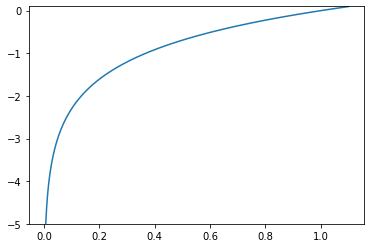

In [5]:
import matplotlib.pyplot as plt
x=np.arange(0.001,1.1,0.001)
y=np.log(x)
plt.plot(x,y)
plt.ylim(-5.0,0.1)
plt.show()

このグラフより、自然対数は$ x $が1の時$ y $の値は0になるため、確率が1に近ければ近いほど値(誤差)は0に近づきます。逆に確率が低ければ－を掛けていることから値(誤差)は大きくなります。

In [6]:
def cross_entropy_error(y,t): #交差エントロピー誤差の定義
    delta=1e-7
    return -np.sum(t*np.log(y+delta))
t=[0,0,1,0,0,0,0,0,0,0]
y=[0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0]
cross_entropy_error(np.array(y),np.array(t))

0.510825457099338

In [7]:
y=[0.1,0.05,0.1,0.0,0.05,0.1,0.0,0.6,0.0,0.0]
cross_entropy_error(np.array(y),np.array(t))

2.302584092994546

それでは一度、ミニバッチに対応した交差エントロピー誤差を実装してみましょう。

In [8]:
def cross_entropy_error1(y,t):
    if y.ndim==1: #データ1つ当たりの交差エントロピー誤差を求める場合
        t=t.reshape(1,t.size)
        y=y.reshape(1,y.size)
    batch_size=y.shape[0]
    return -np.sum(t*np.log(y-1e-7))/batch_size

また、教師データがone_hot表現ではなく「2」や「5」などのラベルとして与えられた場合には以下のように定義します。

In [9]:
def cross_entropy_error2(y,t):
    if y.ndim==1:
        t=t.reshape(1,t.size)
        y=y.reshape(1,y.size)
    batch_size=y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size),t]+1e-7))/batch_size #t(教師ラベル)に対応するニューラルネットワークの出力を出す

精度をそのまま指標化せずに一度損失関数の値を求めるという二度手間をしている理由としては、精度で求めようとすると次にパラメータを微分して勾配を求める際、その値がほとんど0になるか、変化しても不規則であったりするからです。これは精度の変化が(教師データが膨大でない限り)曲線で表せないことを示しています。

## 微分・勾配

微分とはある瞬間の変化の量(傾き)を表したものです。数式では以下のようになります。

$$
   \begin{align}
   \frac{df(x)}{dx} = \lim_{h \to 0}\frac{f(x+h)-f(x)}{h}
   \end{align}
$$

In [10]:
def numerical_diff(f,x):
    h=1e-4 #0.0001
    return (f(x+h)-f(x-h))/(2*h)

この定義には元の数式から2つほど変更点があります。1つは$ h $の値を$ 1e-50 $といった小さすぎる値にしていないこと。あまりに小さくしすぎると小数点以下のいくつかが省略された際に、0.0といった値になってしまう可能性(**丸め誤差**)があるからです。

もう1つは近似による接線を求めた際に生じる誤差を減らすために、$ x $を中心としてその前後の差分を計算していることです。このような計算を**中心差分**といいます(元の計算は**前方差分**)。

実際に、$ y=0.01x^2+0.1x $といった簡単な関数を微分してみましょう。

0.2999999999986347


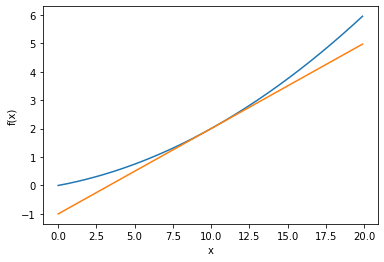

In [11]:
def function_1(x): #関数の定義
    return 0.01*x**2 + 0.1*x 

def tangent_line(f, x): #接線の定義
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y
     
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(function_1, 10) #x=10での接線を求める
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)
plt.show()

続いて、**偏微分**についてみていきましょう。偏微分とは以下のような数式、グラフで表されます。

$$
  f(x_0,x_1)=x_0^2+x_1^2
$$

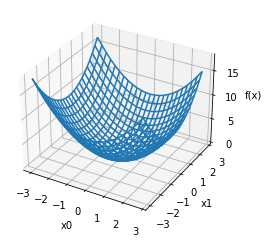

In [12]:
from mpl_toolkits.mplot3d import Axes3D
def function_2(x0,x1):
    return x0**2+x1**2

x=np.arange(-3.0,3.0,0.25)
y=np.arange(-3.0,3.0,0.25)
X,Y=np.meshgrid(x,y)
Z=function_2(X,Y)
fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_zlabel("f(x)")
ax.plot_wireframe(X, Y, Z)
plt.show()

また、偏微分の特徴として「どの変数に対しての微分か」(今回の場合だと$ x_0 $と$ x_1 $)を区別する必要があります。この時の数式は、$ \frac{\partial f}{\partial x_0} $、$ \frac{\partial f}{\partial x_1} $のようにあらわせます。実際に計算してみましょう。

In [13]:
def function_tmp1(x0): #x0=3,x1=4の時のx0に対する偏微分
    return x0*x0+4.0**2.0

print(numerical_diff(function_tmp1,3.0))

def function_tmp2(x1): #x1に対する偏微分
    return 3.0**2.0+x1*x1

print(numerical_diff(function_tmp2,4.0))

6.00000000000378
7.999999999999119


先ほどは区別する必要があると書きましたが、両方の偏微分を$ (\frac{\partial f}{\partial x_0},\frac{\partial f}{\partial x_1}) $のようにまとめることで、ベクトルとして考えることができます。すべての変数の偏微分をベクトルとしてまとめたものを、**勾配**と呼びます。

In [64]:
def function_2_1(x):
    return x[0]**2+x[1]**2
def numerical_gradient(f,x): #勾配の定義
    h=1e-4
    grad=np.zeros_like(x) #xと同じ形状の配列
    for idx in range(x.size):
        tmp_val=x[idx]
        x[idx]=tmp_val+h #f(x+h)
        fxh1=f(x)
        
        x[idx]=tmp_val-h #f(x-h)
        fxh2=f(x)
        
        grad[idx]=(fxh1-fxh2)/(2*h)
        x[idx]=tmp_val
    
    return grad

numerical_gradient(function_2_1,np.array([3.0,4.0])) #点(3,4)の勾配

array([6., 8.])

$ f(x,y)=x^2+y^2 $の勾配を図示してみましょう。

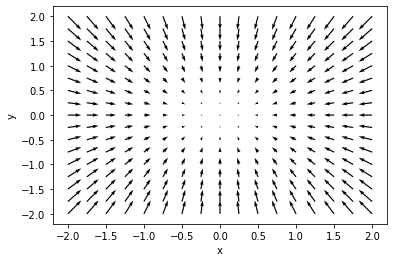

In [15]:
def function_a(x,y): #元の関数
    return x**2+y**2
def function_b(x,y): #xでの偏微分
    return 2*x
def function_c(x,y): #yでの偏微分
    return 2*y

x=np.arange(-2.0,2.1,0.25)
y=np.arange(-2.0,2.1,0.25)
plt.xlabel("x")
plt.ylabel("y")
xx,yy=np.meshgrid(x, y)

function_b_matrix=function_b(xx,yy)
function_c_matrix=function_c(xx,yy)

plt.quiver(xx,yy,-function_b_matrix,-function_c_matrix)
plt.show()

一度まとめとして**勾配降下法**(勾配から最小値を求めること)を実装したいと思います。勾配法は数式で表すと以下のようになります。

$$
   x_0=x_0-\eta\frac{\partial f}{\partial x_0} \\
   x_1=x_1-\eta\frac{\partial f}{\partial x_1}
$$

$ \eta $は更新の量(**学習率**)を表します。

In [16]:
def gradient_descent(f,init_x,lr=0.01,step_num=100):#init_xは初期値、lrは学習値、step_numは勾配法の繰り返しの数 
    x=init_x
    for i in range(step_num):
        grad=numerical_gradient(f,x)
        x-=lr*grad
    return x

init_x=np.array([-3.0,4.0])
gradient_descent(function_2_1,init_x=init_x,lr=0.1,step_num=100) #function_2_1=x0^2+x1^2

array([-6.11110793e-10,  8.14814391e-10])

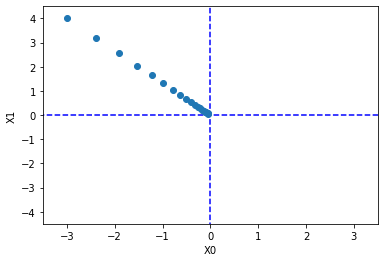

In [17]:
def gradient_descent(f,init_x,lr=0.01,step_num=100):
    x=init_x
    x_history=[]
    for i in range(step_num):
        x_history.append(x.copy())
        grad=numerical_gradient(f, x)
        x-=lr*grad
    return x,np.array(x_history)

init_x=np.array([-3.0, 4.0])
lr=0.1
step_num=20
x, x_history=gradient_descent(function_2_1, init_x, lr=lr, step_num=step_num)

plt.plot([-5, 5],[0,0],'--b')
plt.plot([0,0],[-5, 5],'--b')
plt.plot(x_history[:,0],x_history[:,1],'o')

plt.xlim(-3.5,3.5)
plt.ylim(-4.5,4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

それでは今章の総まとめとして、二層ニューラルネットワークでの確率的勾配降下法を実装してみましょう。まずは二層ニューラルネットワークを一つのクラスとして実装します。

In [7]:
import sys, os
sys.path.append(os.pardir)
from common.functions import *
from common.gradient import numerical_gradient
import numpy as np


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads

これを用いて最初に示した手順通りにニューラルネットワークの学習を繰り返し行っていきます。

In [ ]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

iters_num = 1000  # ハイパーパラメータ
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    # 勾配の計算
    grad = network.numerical_gradient(x_batch, t_batch)
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    #学習記録の更新
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
# グラフの描画
x = np.arange(iters_num)
plt.plot(x, train_loss_list, label='train loss')
plt.xlabel("iteration")
plt.ylabel("loss")
plt.ylim(0, 9)
plt.show()

In [ ]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 1000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()